# Demo NeuroEvolution donde se aplica algoritmo de Programación Genética para generar una RNA (MLP o ConvNet) con librería TF-Keras que pueda aprender a clasificar (atributo clase discreto) o estimar (atributo clase continuo)

Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

In [1]:
#@title Instalar librerías

# instala paquetes DEAP
!pip install deap

# instala paquetes gráficos
!apt-get install -y graphviz-dev
!pip install pygraphviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,03

In [2]:
#@title Cargar librerías
import random
import numpy as np

import operator
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from functools import partial

import random
from random import sample
import copy

import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import display
import tempfile
from PIL import Image

import pickle
import codecs

import matplotlib
import networkx
from IPython.display import display
from PIL import Image

import os
import csv

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import math

import os
import csv

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print("\nLibrerías importadas")


Librerías importadas


# Datos:

In [3]:
#@title Acceder al Drive

# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [4]:

#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Y, X, nombre_clases

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Y = np.array(df[attClase])
  X = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", X.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Y.shape)

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
X = None
Y = None

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  IRIS.csv  cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


In [5]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = False #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

In [6]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "discreto - CLASIFICACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  to_categorical(y_train)
  y_testEnc =  to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


> se considera problema de CLASIFICACIÓN 

> Definición de CLASES: 
 - dictMapeo ( 4 ):  ['na', 'Setosa', 'Versicolor', 'Virginica']

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112
     na [ 0 ]: 0
     Setosa [ 1 ]: 38
     Versicolor [ 2 ]: 37
     Virginica [ 3 ]: 37

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38
     na [ 0 ]: 0
     Setosa [ 1 ]: 12
     Versicolor [ 2 ]: 13
     Virginica [ 3 ]: 13


# Modelo RNA:

In [27]:
#@title Funciones auxiliares para manejar la configuración de RNA con Programación Genética


#@markdown Topología Modelo RNA:
modelo_tipo_red = "MLP" #@param ["MLP", "ConvNet"]
rna_tipo_capa_salida = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]

#@markdown Entrenamiento Modelo RNA:
modelo_cant_epocas_entrenamiento_base = 15 #@param {type:"integer"}

#@markdown Función de Aptitud:
fitness_calc_usando = "Validacion" #@param ["Entrenamiento", "Validacion", "Entrenamiento + Validacion"]
fitness_penalizar_x_topologia = True #@param {type:"boolean"}

# determina datos a usar
if esProblemaClasificacion:
  tipo_output_softMax = (rna_tipo_capa_salida == 'softmax-MultiClase')
else:
  tipo_output_softMax = False

# determina tipo de red
generaConvNet = (modelo_tipo_red == "ConvNet")


import json

# Listas de Opciones de configuración
PG_tipoFuncList = ["relu", "exponential", "linear", "sigmoid", "tanh"]
PG_optTipoList = ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]


# Funciones auxiliares para configuración del modelo en PG

def defaultConfigDictModel(id=None):
    # inicialización de configuración de la red
    # con parámetros por defecto
    configModel = {}
    if id is not None:
      configModel["ID"] = str(id)
    # parámetros entrenamiento
    configModel["epochs"] = max(modelo_cant_epocas_entrenamiento_base, 10)
    # parámetros optimización
    configModel["optTipo"] = "Adam"
    configModel["optLearningRate"] = 0.001
    # parámetros capas ocultas lineales (dense, DO, BN)
    configModel["hiddenLayers"] = "0"
    configModel["funcTipo"] = "relu"
    configModel["porcDropOut"] = 0.1
    # parámetros capas ocultas convNet
    configModel["convLayers"] = (1 if generaConvNet else 0)
    configModel["convKernelShape"] = 2
    configModel["convPoolType"] = "Max"
    configModel["convPoolShape"] = 2
    return configModel

def defaultConfigstrModel(id=None):
    # idem anterio pero devuelve como string
    return strConfig( defaultConfigDictModel(id) )

def strConfig(configDict):
    # convierte config de dict a string
    return json.dumps(configDict)

def dictConfig(configStr):
    # convierte config de string a dict
    return json.loads(configStr)

def showConfigDictModel(configModel):
    # muestra en forma amigable al configuración
    print("\n> Configuración del modelo RNA id: " + configModel["ID"])
    if configModel["convLayers"] > 0:
        print("\t con " + str(configModel["convLayers"]) + " capas convolucionales:")
        print("\t\t kernel shape: " + str(configModel["convKernelShape"]))
        print("\t\t pooling tipo: " + str(configModel["convPoolType"]) + " y shape: " + str(configModel["convPoolShape"]))
    if configModel["hiddenLayers"] == "0":
        print("\t sin capas ocultas lineales ")
    else:
        listaOcultas = configModel["hiddenLayers"].split(",")
        print("\t con " + str(len(listaOcultas)-1) + " capas ocultas:")
        print("\t\t función neuronas: " +configModel["funcTipo"])
        if "D" in listaOcultas:
          print("\t\t porcentaje DropOut: " + str(configModel["porcDropOut"]))
    print("\t algoritmo de optimización: " + configModel["optTipo"] + ", learning rate: " + str(configModel["optLearningRate"]) )
    print("\t y entrenamiento con " + str(configModel["epochs"]) + " épocas.")
    print("")

# Primitivas para manejar configuración del modelo en PG

def configFuncLayers(configStr, tipoFuncionInt):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura tipo de función para capas Conv y Dense
    if (tipoFuncionInt>=0):
      auxId = tipoFuncionInt % len(PG_tipoFuncList)
      configModel["funcTipo"] = PG_tipoFuncList[auxId]
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def addDenseLayer(configStr, cantNeuronas):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # agrega una capa Dense (MLP)
    if cantNeuronas>0:
      configModel["hiddenLayers"] = configModel["hiddenLayers"] + "," + str(cantNeuronas)
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def addBatchNormalizationLayer(configStr):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # agrega una capa BatchNormalization
    configModel["hiddenLayers"] = configModel["hiddenLayers"] + ",BN"
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def addDropOutLayer(configStr):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # agrega una capa DropOut
    configModel["hiddenLayers"] = configModel["hiddenLayers"] + ",D"
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configDropOut(configStr, porcInt):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura porcentaje de capas DropOuts
    if porcInt<0:
      porcInt = 1
    elif porcInt>90:
      porcInt = 90
    configModel["porcDropOut"] = float(porcInt)/100.0
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def addConvLayer(configStr):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # agrega una capa convolucional completa (nota: siempre van adelante de las 'hidden')
    configModel["convLayers"] = configModel["convLayers"] + 1
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configConvLayers(configStr, cantLayers):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura una cantidad capas Convs completas
    # (nota1: sobreescribe configuración anterior de cantidad de capas convs)
    # (nota2: siempre van adelante de las 'hidden')
    if cantLayers<0:
      cantLayers = 0
    elif cantLayers>10:
      cantLayers = (cantLayers % 10)+1
    configModel["convLayers"] = cantLayers
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configConvKernelShape(configStr, shape):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura kernel shape de etapas Convs (si están disponibles)
    if shape<1:
      shape = 1
    elif shape>10:
      shape = (shape % 10)+1
    configModel["convKernelShape"] = shape
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configPoolShape(configStr, shape):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # determina shape de etapas Poolings (si están disponibles)
    if shape<1:
      shape = 1
    elif shape>10:
      shape = (shape % 10)+1
    configModel["convPoolShape"] = shape
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configPoolType(configStr, tipoInt):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # determina tipo de etapas Poolings (si están disponibles)
    if (tipoInt % 2)==0:
      auxTipo = "Max"
    else:
      auxTipo = "Avg"
    configModel["convPoolType"] = auxTipo
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configAlgOpt(configStr,  optTipoInt):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura algoritmo de optimización
    if (optTipoInt>=0):
      auxId = optTipoInt % len(PG_optTipoList)
      configModel["optTipo"] = PG_optTipoList[auxId]
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

def configLearnRate(configStr, learningRateInt):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura learning reate
    if learningRateInt>0:
      configModel["optLearningRate"] = float(learningRateInt)/100.0
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)


def addEpochs(configStr, epochs):
    # prepara config para poder usarlo
    configModel = dictConfig(configStr)
    # configura learning reate
    if epochs>0:
      configModel["epochs"] = configModel["epochs"] + epochs
    # convierte config para poder manejarlo en PG
    return strConfig(configModel)

print("Funciones para configuración de RNA definidas.")

Funciones para configuración de RNA definidas.


In [8]:
#@title Definir clase auxiliar para el ambiente para RNA con Programación Genética

#@markdown Parámetros:
rna_env_cache_en_memoria = False #@param {type:"boolean"}
rna_env_debug = False #@param {type:"boolean"}


# configuración del enviroment
configRNAEnv = {}
if fitness_calc_usando == "Entrenamiento":
  configRNAEnv["calcFitness"] = "E"
elif fitness_calc_usando == "Validacion":
  configRNAEnv["calcFitness"] = "V"
else:
  configRNAEnv["calcFitness"] = "E+V"
configRNAEnv["penalFitness"] = fitness_penalizar_x_topologia
configRNAEnv["cacheInMemory"] = rna_env_cache_en_memoria


# constantes auxiliares
cons_WorstValue = -99.9
cont_BestValue = 100.0

# clase
class RNA_PG_Environment(object):

    def __init__(self, x_data, y_data, esProblemaClasificacion=False,
                 config=None, DEBUG=False):
        # inicializa el ambiente para usar Programación Genética
        print("> Preparando el ambiente...")
        self.DEBUG = DEBUG

        # calida parámetros de data
        assert x_data is not None, "-- x_data no definido!"
        assert len(x_data)>0, "-- x_data vacío!"
        assert y_data is not None, "--  y_data no definido!"
        assert len(y_data)>0, "-- y_data vacío!"

        if config is None:
            # define parámetros por defecto
            self.calcFitness = "V"
            self.penalFitness = True
            self.cacheInMemory = True
        else:
            self.calcFitness = config["calcFitness"]
            self.penalFitness = config["penalFitness"]
            self.cacheInMemory = configRNAEnv["cacheInMemory"]

        if esProblemaClasificacion:
            # para problema de clasificación
            print(" Configurado para problema de Clasificación.")
            self.esClasificacion = True
            # determina neuronas de entrada y salida
            self.x_cantAtt = x_data.shape[1]
            # determina si es salida softmax o no
            if len(y_data.shape)==1:
              self.y_cantAtt = 1
            else:
              self.y_cantAtt = y_data.shape[1]
        else:
            # para problema de Estimación
            print(" Configurado para problema de Estimación.")
            self.esClasificacion = False
            # determina neuronas de entrada y salida
            self.x_cantAtt = x_data.shape[1]
            self.y_cantAtt = 1
        self.dataLength = len(x_data)

        # valida resultados previos
        assert self.dataLength > 0, "-- dataLength debe ser mayor a 0"
        assert self.x_cantAtt > 0, "-- x_cantAtt debe ser mayor a 0"
        assert self.y_cantAtt > 0, "-- y_cantAtt debe ser mayor a 0"

        print(" Definiendo parámetros para cálculo de aptitud: ")
        print("        calcFitness = ", self.calcFitness)
        print("        penalFitness = ", self.penalFitness)

        if self.calcFitness == "E":
            # se toman todos los datos para entrenamiento
            self.x_train, self.y_train, x_data, y_data
            self.x_val, self.y_val = [], []
            self.x_eval, self.y_eval = x_data, y_data
        else:
            # separa al azar usando muestreo al azar del 10%
            # para tomar algunos como datos de validación
            self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(x_data, y_data,
                                                                                    test_size=0.1)
            if self.calcFitness == "V":
              # para calculo de fitness (eval) se usa solamente los de validación
              self.x_eval, self.y_eval = self.x_val, self.y_val
            else: #  "E+V":
              # para calculo de fitness (eval) se usan todos (pero los de validación no se usan para entrenar)
              self.x_eval, self.y_eval = x_data, y_data

        print("  Definiendo datos: de los ", len(x_data), "ejemplos de entrenamiento: ")
        print("                      se usan ", len(self.x_train), "ejemplos para entrenar ")
        print("                      se usan ", len(self.x_val), "ejemplos para validar")
        print("                      y ", len(self.x_eval), "ejemplos para calcular fitness.")

        # prepara datos entrenamiento como array
        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train).reshape(len(self.y_train), self.y_cantAtt)
        # prepara datos validación como array
        self.x_val = np.array(self.x_val)
        self.y_val = np.array(self.y_val).reshape(len(self.y_val), self.y_cantAtt)
        # prepara datos evaluación
        self.x_eval = np.array(self.x_eval)
        self.y_eval = np.array(self.y_eval).reshape(len(self.y_eval), self.y_cantAtt)

        # valida resultados
        assert self.x_train is not None, "--  x_train no definido!"
        assert len(self.x_train)>0, "-- x_train vacío!"
        assert self.y_train is not None, "-- y_train no definido!"
        assert len(self.y_train)>0, "-- y_train vacío!"
        assert self.x_eval is not None, "--  x_eval no definido!"
        assert len(self.x_eval)>0, "-- x_eval vacío!"
        assert self.y_eval is not None, "-- y_eval no definido!"
        assert len(self.y_eval)>0, "-- y_eval vacío!"

        print(" Topología base de la red: ")
        print("\t -Capa Entrada: ", self.x_cantAtt,  " / x_train: ",  self.x_train.shape)
        print("\t -Capa Salida: ", self.y_cantAtt,  " / y_train " ,  self.y_train.shape)
        print("\n")

        self.models_cache_reset()
        return


    # * Manejo del modelo RNA

    def _create_model(self, configModel):
      assert configModel is not None, "-- create_model: configuración de modelo no definida!"
      # crea la red en base a la configuración dada
      penalFitnessVal = 0
      model = keras.Sequential()
      model.name = "Model_" + configModel.get("ID", "?")
      if self.DEBUG:
        print("\n- create_model: ")
        for k in configModel:
            print("\t ", k, " = ", configModel[k])
        print("")
      # agrega capa de entrada
      model.add( keras.layers.Input(shape=(self.x_cantAtt,), name='input') )
      # define parámetros generales para capas
      funcTipo = configModel["funcTipo"]
      porc_DropOut = configModel["porcDropOut"]
      if "," in configModel["hiddenLayers"]:
        hiddLayers = configModel["hiddenLayers"].split(',')
      else:
        hiddLayers = [ configModel["hiddenLayers"] ]
      idHiddLay = 0
      # procesa capas Convolucionales (si corresponde)
      if configModel["convLayers"]>0:
          # parámetros para capas convolucionales
          cnn_kernel_shape = configModel["convKernelShape"]
          cnn_pooling_shape = configModel["convPoolShape"]
          if configModel["convPoolType"] == "Max":
              cnn_pooling_layer = keras.layers.MaxPooling1D
          else:
              cnn_pooling_layer = keras.layers.AveragePooling1D
          #  agrega capa Reshape para que pueda ser procesado por capas convolucionales
          matrixShape = None
          for val in [2, 3, 5, 7, 11]:
            if (self.x_cantAtt%val)==0:
              matrixShape = [val,(self.x_cantAtt//val)]
              break
          if matrixShape is None:
            matrixShape = [1, self.x_cantAtt]
          model.add( keras.layers.Reshape( matrixShape, name="reshape_input" ) )
          # agrega capas convolucionales
          for i in range(configModel["convLayers"], 0, -1):
              cnn_filters = 2**(i+2)
              idHiddLay += 1
              auxlayerName = 'conv_c_'+str(idHiddLay)
              model.add( keras.layers.Conv1D(cnn_filters, cnn_kernel_shape, activation=funcTipo, padding='same', name=auxlayerName) )
              auxlayerName = 'conv_p_'+str(idHiddLay)
              model.add( cnn_pooling_layer(cnn_pooling_shape, padding='same', name=auxlayerName) )
              penalFitnessVal -= 0.05
          #  agrega capa Flatten
          model.add( keras.layers.Flatten(name='flat') )
      # procesa capas ocultas MLP (si corresponde)
      for val in hiddLayers:
          idHiddLay += 1
          val = val.strip()
          if val == "D":
              # capa Dropout
              auxlayerName = "do_"+str(idHiddLay)
              model.add( keras.layers.Dropout(porc_DropOut, name=auxlayerName) )
              penalFitnessVal -= 0.08
          elif val == "BN":
              # capa BatchNormalization
              auxlayerName = "bn_"+str(idHiddLay)
              model.add( keras.layers.BatchNormalization(name=auxlayerName) )
              penalFitnessVal -= 0.08
          elif val.isnumeric():
              # capa dense
              if int(val)>0:
                auxlayerName = "h_"+str(idHiddLay)
                model.add( keras.layers.Dense(int(val), activation=funcTipo, name=auxlayerName) )
                penalFitnessVal -= float(val)/1000.0
              else:
                idHiddLay -= 1
          else:
            print("-- create_model: capa ", val, "descartada!")
            idHiddLay -= 1
            penalFitnessVal -= 1
      # agrega capa de salida
      esSoftMax = ( self.esClasificacion and self.y_cantAtt>1 )
      if esSoftMax:
        model.add( keras.layers.Dense(units=self.y_cantAtt, activation="softmax", name='output') )
      else:
        model.add( keras.layers.Dense(units=1, activation=None, name='output') )
      # define algoritmo de optimización
      if configModel["optTipo"] == "Gradiente Decreciente":
        opt = keras.optimizers.SGD(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "Adam":
        opt = keras.optimizers.Adam(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "Adadelta":
        opt = keras.optimizers.Adadelta(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "Adagrad":
        opt = keras.optimizers.Adagrad(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "Adamax":
        opt = keras.optimizers.Adamax(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "Nadam":
        opt = keras.optimizers.Nadam(learning_rate=configModel["optLearningRate"])
      elif configModel["optTipo"]  == "FTRL":
        opt = keras.optimizers.Ftrl(learning_rate=configModel["optLearningRate"])
      else:
        opt = keras.optimizers.Adam()
      # compila modelo
      # notar que métrica (accuracy o R2 score) devuelve valor entre 0 y 1 (peor->mejor)
      if esSoftMax:
          # utiliza un loss de multiple clases
          model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
      else:
          # utiliza un loss de valor numérico
          if self.esClasificacion :
            model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
          else:
            model.compile(optimizer=opt, loss='mse', metrics=['R2Score'])
      return model, penalFitnessVal


    def _train_model(self, model, cantEpocas):
      # valida datos
      assert model is not None, "-- train_model: modelo no definido!"
      # valida cantidad de épocas
      cantEpocas = (1 if cantEpocas<1 else cantEpocas)
      # realiza el entrenamiento
      history = model.fit(self.x_train, self.y_train,
                              epochs = cantEpocas,
                              verbose = (1 if self.DEBUG else 0))
      # ver que datos extraer para cálculo de heurística
      return model, history


    def _eval_model(self, model, showDetails=False):
      # valida datos
      assert model is not None, "-- eval_model: modelo no definido!"
      # evalua el modelo
      resEval = model.evaluate(self.x_eval, self.y_eval,
                                    verbose=(1 if self.DEBUG else 0))
      modelMetric = resEval[1]
      if math.isnan(modelMetric):
        if self.DEBUG:
          print("-- eval_model: métrica modelo no definida, se cambia.")
        modelMetric = 0.0001
      elif modelMetric < 0:
        if self.DEBUG:
          print("-- eval_model: métrica modelo menor a cero, se cambia.")
        modelMetric = 0.0001
      else:
        modelMetric = round(modelMetric* 100.0, 4)
      if self.DEBUG or showDetails:
          print("\n- eval_model: métricas ")
          print("\t- Loss: ", round(resEval[0],3))
          print("\t- Métrica: ", modelMetric)
      return modelMetric


    def show_model(self, model, showPlot=True):
      # muestra el modelo generado
      assert model is not None, "-- show_model: modelo no definido!"
      print("Modelo creado con ", len(model.layers), " capas:")
      model.summary()
      print("\n")
      if showPlot:
        display( plot_model(model, show_layer_names=True, show_shapes=True) )
        print("")

    # * Funciones para calcular Fitness

    def calculate_fitness(self, configModel):
        # calcula valor de aptitud del modelo
        try:
            # crea el modelo
            indModel, indPenalFitness = self._create_model(configModel)
            if self.DEBUG:
              self.show_model(indModel, showPlot=False)
            # entrena modelo
            indModel, hist = self._train_model(indModel, configModel["epochs"])
            # evalúa al modelo
            indHeuristica = self._eval_model(indModel)
            # penaliza si corresponde
            if self.penalFitness:
              indHeuristica = indHeuristica + indPenalFitness/10.0
            # devuelve heuristica
            return round(indHeuristica, 4), indModel
        except Exception as e:
          if self.DEBUG:
            print("Error calculate_fitness: ", e)
          return cons_WorstValue, None

    def return_MaxFitness(self):
      # devuelve valor máximo posible para la aptitud
      return cont_BestValue


    # * Funciones para manejo de cache

    def _save_model(self, model, modelId, path="."):
      # guarda el modelo
      assert model is not None, "-- save_model: modelo no definido!"
      # si no existe el directorio, lo crea
      if (path!="."):
        if not os.path.isdir(path):
          os.makedirs(path)
      fn_model = path+"/model-" + modelId + ".keras"
      model.save(fn_model)
      if self.DEBUG:
        print("\n- save_model: guardado en ", fn_model,"\n")
      return fn_model


    def _load_model(self, fn_model):
      # recupera el modelo
      model = keras.models.load_model(fn_model)
      if self.DEBUG:
        print("\n- _load_model: recuperado de ", fn_model,"\n")
      return model

    @staticmethod
    def getIndividualId(individual):
      return hash(str(individual))

    def models_cache_reset(self):
      # inicializa cache rna
      self.cacheIndRna = {}
      self.cachePath = tempfile.TemporaryDirectory(prefix="cacheModels_").name
      if self.DEBUG:
        print("\n- models_cache_reset: cache inicializada en ", self.cachePath)

    def models_cache_get(self, individual):
      # se fija si está en la cache rna y lo devuelve
      # sino devuelve que no lo encuentra
      id = RNA_PG_Environment.getIndividualId(individual)
      if id in self.cacheIndRna:
        data = self.cacheIndRna[id]
        if self.cacheInMemory:
          model = data[2]
          if self.DEBUG:
            print("\n- models_cache_get: id ", id, "encontrado en memoria")
        else:
          # recupera el modelo guardado en archivo
          model = self. _load_model(data[2])
          if self.DEBUG:
            print("\n- models_cache_get: id ", id, "encontrado en archivo")
        # devuelve lo recuperado
        return True, id, data[0], data[1], model
      else:
        if self.DEBUG:
          print("\n- models_cache_get: id ", id, "no encontrado")
        # devuelve que no lo encuentra
        return False, id, cons_WorstValue, None, None

    def models_cache_set(self, individual, fitness, configModel, model):
        # guarda individual en la cache (si ya existía lo sobreescribe)
        id = RNA_PG_Environment.getIndividualId(individual)
        if self.cacheInMemory:
          # guarda directo en la cache
          self.cacheIndRna[id] = (fitness, configModel, model)
          if self.DEBUG:
            print("\n- models_cache_set: id ", id, "guardado en memoria")
        else:
          # guarda el modelo como archivo para liberar memoria
          fn_model = self._save_model(model, modelId=str(id), path=self.cachePath)
          self.cacheIndRna[id] = (fitness, configModel, fn_model)
          if self.DEBUG:
            print("\n- models_cache_set: id ", id, "guardado en archivo: ", fn_model)
        return True

print("Clase RNA_PG_Environment definida")

# inicializa la clase enviroment
modeloEnv = RNA_PG_Environment(x_data=x_train,
                           y_data=(y_trainEnc if tipo_output_softMax else y_train),
                           esProblemaClasificacion=esProblemaClasificacion,
                           config=configRNAEnv,
                           DEBUG=rna_env_debug)

print("\nRNA_PG_Environment inicializado")

Clase RNA_PG_Environment definida
> Preparando el ambiente...
 Configurado para problema de Clasificación.
 Definiendo parámetros para cálculo de aptitud: 
        calcFitness =  V
        penalFitness =  True
  Definiendo datos: de los  112 ejemplos de entrenamiento: 
                      se usan  100 ejemplos para entrenar 
                      se usan  12 ejemplos para validar
                      y  12 ejemplos para calcular fitness.
 Topología base de la red: 
	 -Capa Entrada:  4  / x_train:  (100, 4)
	 -Capa Salida:  4  / y_train  (100, 4)



RNA_PG_Environment inicializado


# Algoritmo de Programación Genética:

In [9]:
#@title PARÁMETROS del ALGORITMO

#@markdown Parámetros del Algoritmo de Programación Genética (PG):

# Cantidad de Ciclos de la Corrida
CANT_CICLOS =  15#@param {type:"integer"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 6 #@param {type:"slider", min:1, max:100, step:1}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [10]:
#@title DEFINE LAS PRIMITIVAS DEL CROMOSOMA

incluir_primitivas_logicas = False #@param{"type":"boolean"}


# Agrega otras primitivas para Cromosoma

def pdiv(left, right):
    try:
        return int( int(left) // int(right) )
    except:
        return 1

# Define a new if-then-else function
def if_then_else(input, output1, output2):
    if input: return output1
    else: return output2

def comp_iguales(val1, val2):
    return (val1 == val2)

def comp_mas_grande(val1, val2):
    return (val1 > val2)

def comp_mas_chico(val1, val2):
    return (val1 < val2)


print("Funciones para Primitivas definidas.")


# Configura las primitivas permitidas para usar
# algunas son configurables (opcionales) y otras no
pset = gp.PrimitiveSetTyped("MAIN", [str, int, int, int], str)
# para manejo de configuración del modelo
pset.addPrimitive(configFuncLayers, [str, int], str)
pset.addPrimitive(addDenseLayer, [str, int], str)
pset.addPrimitive(addBatchNormalizationLayer, [str], str)
pset.addPrimitive(addDropOutLayer, [str], str)
pset.addPrimitive(configDropOut, [str, int], str)
if generaConvNet:
  pset.addPrimitive(addConvLayer, [str], str)
  pset.addPrimitive(configConvLayers, [str, int], str)
  pset.addPrimitive(configConvKernelShape, [str, int], str)
  pset.addPrimitive(configPoolShape, [str, int], str)
  pset.addPrimitive(configPoolType, [str, int], str)
pset.addPrimitive(configAlgOpt, [str, int], str)
pset.addPrimitive(configLearnRate, [str, int], str)
pset.addPrimitive(addEpochs, [str, int], str)
# aritméticas básicas
pset.addPrimitive(operator.add, [int, int], int)
pset.addPrimitive(operator.sub, [int, int], int)
pset.addPrimitive(operator.mul, [int, int], int)
pset.addPrimitive(pdiv, [int, int], int)
pset.addPrimitive(max, [int, int], int)
pset.addPrimitive(min, [int, int], int)
# constantes numéricas
pset.addEphemeralConstant("constA",  partial(random.randint, 0, 100), int)
pset.addEphemeralConstant("constB",  partial(random.randint, 0, 100), int)
pset.addEphemeralConstant("constC",  partial(random.randint, 0, 100), int)
if incluir_primitivas_logicas:
  # lógicas
  pset.addPrimitive(operator.and_, [bool, bool], bool)
  pset.addPrimitive(operator.or_, [bool, bool], bool)
  pset.addPrimitive(operator.not_, [bool], bool)
  pset.addPrimitive(comp_iguales, [int, int], bool)
  pset.addPrimitive(comp_mas_grande, [int, int], bool)
  pset.addPrimitive(comp_mas_chico, [int, int], bool)
  pset.addPrimitive(if_then_else, [bool, str, str], str)
  pset.addEphemeralConstant("cTrue",  True, bool)
  pset.addEphemeralConstant("cFalse",  False, bool)



# parámetros del algortimo
pset.renameArguments(ARG0='configModelo')
pset.renameArguments(ARG1='x_cantAtts')
pset.renameArguments(ARG2='y_cantAtts')
pset.renameArguments(ARG3='data_length')

print("\nPrimitivas definidas")

Funciones para Primitivas definidas.

Primitivas definidas


In [15]:
#@title FUNCIÓN DE APTITUD Y ESTRUCTURA DEL CROMOSOMA

#@markdown > Función de Aptitud:
#@markdown - indica que es para maximizar.
#@markdown - determina la aptitud a partir de la métrica de la RNA entrenada

# indica que es la función de aptitud es para maximizar la métrica del modelo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


# función auxiliar para aplicar la expresión
# nota: usa una cache de los modelos para agilizar el proceso
def aplicaExpresion(individual, debug=False):
  try:
    if debug:
        print("\n - Expresion:", individual)
    # se fija si está en la cache
    isCached, idInd, fitness, dicConfigMod, model = modeloEnv.models_cache_get(individual)
    if isCached:
        if debug:
          print("\t recuperado de cache--> fitness:", fitness)
    else:
        # si encuentra en cache lo devuelve
        # Transforma la expresión del árbol en una función que se puede ejecutar
        func = toolbox.compile(expr=individual)
        # genera config incial y aplica las funcs del individuo
        # para definir la configuración del modelo
        strConfigMod = defaultConfigstrModel(idInd)
        strConfigMod = func(strConfigMod, modeloEnv.x_cantAtt, modeloEnv.y_cantAtt, modeloEnv.dataLength)
        # calcula aptitud en base a la configuración definida
        dicConfigMod = dictConfig(strConfigMod)
        fitness, model = modeloEnv.calculate_fitness(configModel=dicConfigMod)
        if debug:
          print("\t\t --> fitness:", fitness)
        # guarda en cache
        modeloEnv.models_cache_set(individual, fitness, dicConfigMod, model)
    # devuelve resultados
    return fitness, dicConfigMod, model
  except Exception as e:
    if debug:
      print("Error en aplicaExpresion: ", e)
    return cons_WorstValue, None, None

# función auxiliar para calcular la aptitud
def calculaAptitud(individual):
  # muestra progreso
  print(".", end="")
  # aplica la expresión del individuo y devuelve la aptitud
  aptitud, _ , _=  aplicaExpresion(individual, debug=False)
  return aptitud,

def formatearIndividuo(individual):
  return str(individual)

toolbox.register("evaluate", calculaAptitud)

print("\nFunción de Aptitud y Cromosoma definidos")


Función de Aptitud y Cromosoma definidos


In [16]:
#@title  OPERADORES GENÉTICOS
## (ver lista completa en https://deap.readthedocs.io/en/master/api/tools.html#operators )

tipo_seleccion = 'Torneo' #@param ["Torneo", "Ranking"]

#@markdown  #####tipo_cruzamiento = 'Simple 1 punto corte'

# Probabilidad del Mutación
probab_mutacion = 0.8 #@param {type:"slider", min:0, max:1, step:0.05}


# Registrar tipo de Selección a aplicar con sus parámetros
if tipo_seleccion == 'Torneo':
  toolbox.register("select", tools.selTournament, tournsize=2)
elif tipo_seleccion == 'Ranking':
  toolbox.register("select", tools.selBest)
elif tipo_seleccion == 'Ruleta':
  toolbox.register("select", tools.selRoulette)
elif tipo_seleccion == 'Estocastica':
  toolbox.register("select", tools.selStochasticUniversalSampling)
else:
  toolbox.register("select", tools.selRandom)

# Registrar tipo de Cruzamiento a aplicar con sus parámetros
toolbox.register("mate", gp.cxOnePoint)

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# define parámetros adicionales para evitar el BLOAT
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=15))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


In [13]:
#@title FUNCIONES AUXILIARES

## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud
    if len(indivPobla) == 0:
      return None, 0, 0, 0
    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    for ind in indivPobla:
        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt
        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
    auxProm = round(auxSum / len(indivPobla), 2)
    if mejorMax:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    else:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values > auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )
    if muestra:
        print("\n-- Ciclo  %i --" % ciclo)
        print(" ++ Mejor Individuo:", auxBestInd, " {", round(auxBestIndApt, 3), "}")
        print("      Max: ", round(auxMax, 3), " / Promedio: ", round(auxProm, 3), " / Min: ", round(auxMin, 3))
    return auxBestInd, auxMax, auxProm, auxMin


def asignarAptitud(indivPobla):
  # Asigna el valor de aptitud a los individuos
  fitnesses = list(map(toolbox.evaluate, indivPobla))
  for ind, fit in zip(indivPobla, fitnesses):
      ind.fitness.values = fit[0],
  return fitnesses


def mostrarParamsDetalle():
  print("EJECUCIÓN DE LA CORRIDA: ")
  print("\t Criterio de Paro: "+str(CANT_CICLOS)+" ciclos, o si llega a una heurística mayor a: ", round(MIN_HEURISTICA_FINALIZAR,3) )
  print("\t Tamaño de la Población: "+str(CANT_INDIVIDUOS_POBLACION)+" individuos.")
  print("\t Método de Selección: "+tipo_seleccion+".")
  print("\t Método de Mutación: Simple con "+str(probab_mutacion*100)+"% de probabilidad.")
  print("")


print("\nFunciones auxiliares definidas")


Funciones auxiliares definidas


In [24]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = cont_BestValue - 0.001

# cálcula cantidad de individuos seleccionados como la mitad + 1
cant_ind_selecc = (CANT_INDIVIDUOS_POBLACION//2)+1

# inicializa cache rna en cada ejecución
modeloEnv.models_cache_reset()

# vectores auxiliares
ciclo = 1
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

print("-- Generando población inicial")

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
fitnesses = asignarAptitud(indivPobla)
ciclosIndiv.append( [] )
ciclosIndiv[0].extend( indivPobla )
print("")

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)

# Finaliza cuando llegue a la cantidad de ciclos
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0]<MIN_HEURISTICA_FINALIZAR)):

    # Realiza la Selección
    indivSelecc = toolbox.select(indivPobla, cant_ind_selecc)

    # Realiza el Cruzamiento
    # por cada individuo seleccionado los clona (sino pueden afectarle los cambios)
    # y luego le busca una pareja al azar dentro de los seleccionados para generar 2 hijos
    indivHijos = []
    for hijo1 in list(map(toolbox.clone, indivSelecc)):
      if len(indivHijos) < len(indivPobla):
        # todavía falta generar hijos
        hijo2 = list(map(toolbox.clone, random.sample(indivSelecc, 1)))[0]
        # hace el cruzamiento
        toolbox.mate(hijo1, hijo2)
        del hijo1.fitness.values
        del hijo2.fitness.values
        # agrega 1er hijo
        indivHijos.append(hijo1)
        if len(indivHijos) < len(indivPobla):
          # agrega 2do hijo
          indivHijos.append(hijo2)
      else:
        break

    # controla que mantenga que los hijos
    # tenga la misma cantidad de individuos que la población original
    if len(indivHijos) != len(indivPobla):
      print("ERROR: distinta cantidad de individuos hijos ", len(indivHijos) , " | ", len(indivPobla))

    # Realiza la Mutación
    if random.random() < probab_mutacion:
      # ejecuta mutación:
      # selecciona al azar el individuo a mutar
      # y lo muta aplicando el método
      mutant = indivHijos[random.randint(0, len(indivHijos)-1)]
      # hace la mutación
      toolbox.mutate(mutant)
      del mutant.fitness.values

    # Evalua a los individuos hijos que salen de Cruzamiento & Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivHijos if not ind.fitness.valid]
    fitnesses = asignarAptitud(invalid_ind)
    print("")

    # Reemplaza la población actual con los hijos
    indivPobla[:] = indivHijos
    ciclosIndiv.append( [] )
    ciclosIndiv[ciclo].extend( indivPobla )

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )

print("== Mejor Individuo de la Corrida:", mejorIndCorrida, " { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")


-- Generando población inicial
......

-- Ciclo  0 --
 ++ Mejor Individuo: addDenseLayer(configLearnRate(configModelo, x_cantAtts), min(x_cantAtts, x_cantAtts))  { 58.33 }
      Max:  58.33  / Promedio:  55.55  / Min:  41.66
......

-- Ciclo  1 --
 ++ Mejor Individuo: addEpochs(configLearnRate(configLearnRate(configDropOut(configLearnRate(addEpochs(configModelo, 88), sub(89, data_length)), pdiv(mul(31, data_length), max(23, 31))), pdiv(sub(max(x_cantAtts, x_cantAtts), sub(x_cantAtts, data_length)), sub(sub(x_cantAtts, y_cantAtts), pdiv(data_length, x_cantAtts)))), pdiv(sub(max(x_cantAtts, x_cantAtts), sub(x_cantAtts, data_length)), sub(sub(x_cantAtts, y_cantAtts), pdiv(data_length, x_cantAtts)))), mul(pdiv(add(pdiv(x_cantAtts, data_length), min(y_cantAtts, 43)), mul(pdiv(78, x_cantAtts), add(18, data_length))), min(min(add(87, 63), sub(11, 45)), mul(add(data_length, y_cantAtts), sub(y_cantAtts, y_cantAtts)))))  { 58.33 }
      Max:  58.33  / Promedio:  40.27  / Min:  16.67
......

-- C

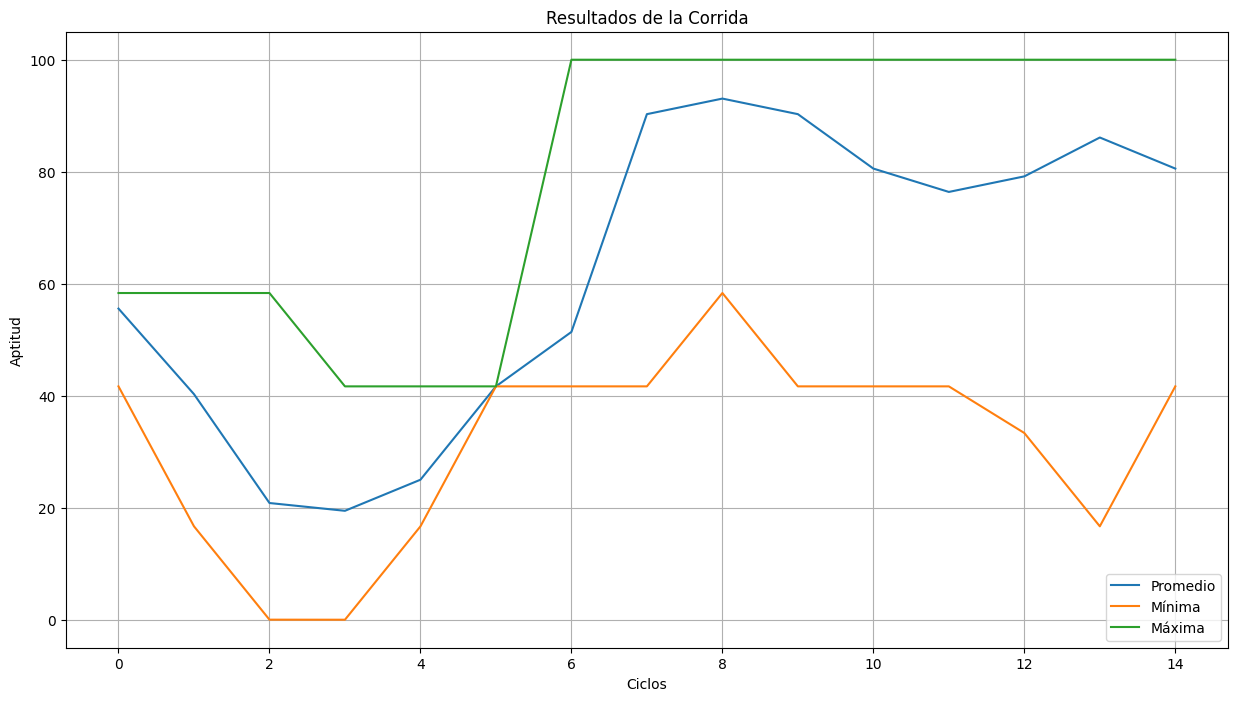

In [25]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.grid(True)
plt.show()


# Evaluación del mejor Modelo encontrado

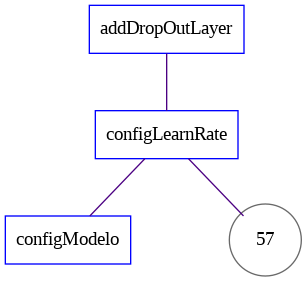


== Mejor Individuo de la Corrida: addDropOutLayer(configLearnRate(configModelo, 57))  {  99.992  }  ==

> Configuración del modelo RNA id: 6977299023602252720
	 con 1 capas ocultas:
		 función neuronas: relu
		 porcentaje DropOut: 0.1
	 algoritmo de optimización: Adam, learning rate: 0.57
	 y entrenamiento con 15 épocas.

Modelo creado con  2  capas:


Model: "Model_6977299023602252720"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ do_1 (Dropout)                       │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 4)                   │              20 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62 (252.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42 (172.00 B)

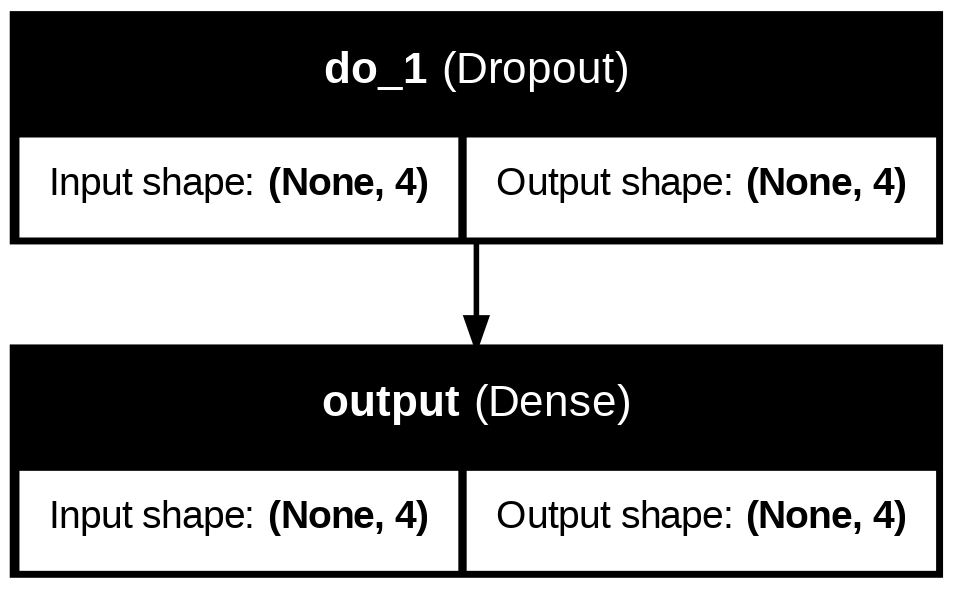

In [28]:
#@title Mostrar Mejor Modelo

nodes, edges, labels = gp.graph( mejorIndCorrida )

#g = pgv.AGraph()
g = pgv.AGraph(overlap=False, splines='polyline') # indica tipo de uniones
g.graph_attr['label']='' # título
g.graph_attr['ranksep']='0.6' # separación entre niveles
g.graph_attr['nodesep']='1.3' # separación en el mismo nivel

g.node_attr['shape']='box'
g.node_attr['color']='blue'
g.edge_attr['color']='indigo'
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]
    if labels[i]=='CantParts' or labels[i]=='Particulas':
      n.attr['shape']='oval'
      n.attr['color']='cyan4'
    elif str(labels[i]).isnumeric():
      n.attr['shape']='circle'
      n.attr['color']='dimgray'

# genera una imagen temporal con el árbol y la muestra
auxFile = tempfile.NamedTemporaryFile(suffix=".png")

g.draw(auxFile.name,format="png")
display(Image.open(auxFile.name))

# muestra mejor individuo
print("")
print("== Mejor Individuo de la Corrida:", mejorIndCorrida, " { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")

# recupera RNA generada por el mejor indiviudo
isCached, mejorIndId, mejorIndFitness, mejorIndconfigModel, model = modeloEnv.models_cache_get(mejorIndCorrida)
if not isCached:
    print("\n--Warning: individuo no encontrado en cache, regenera!")
    mejorIndFitness, mejorIndconfigModel, model = aplicaExpresion(mejorIndCorrida)
# muestra configuración
showConfigDictModel(mejorIndconfigModel)
# muestra modelo
modeloEnv.show_model(model, showPlot=True)

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        38
  Versicolor       1.00      0.78      0.88        37
   Virginica       0.82      1.00      0.90        37

    accuracy                           0.93       112
   macro avg       0.94      0.93      0.93       112
weighted avg       0.94      0.93      0.93       112


Matriz de Confusión ( real / modelo ): 
              m:Setosa  m:Versicolor  m:Virginica
r:Setosa            38             0            0
r:Versicolor         0            29            8
r:Virginica          0             0           37




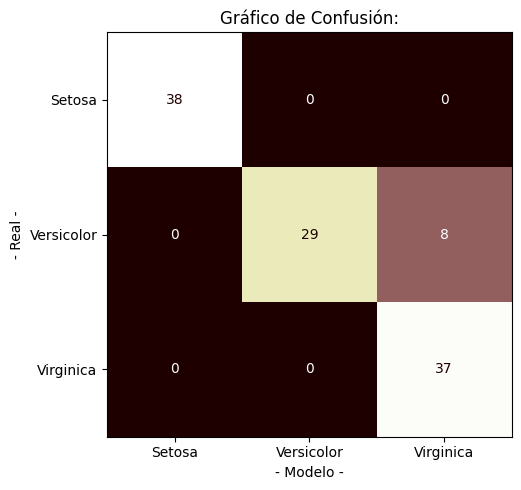

In [29]:
#@title Evaluar red entrenada con datos de entrenamiento

umbral_clasificacion = 50 # param {type:"slider", min:1, max:99, step:1}
mostrar_detalle_entrenamiento = False #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}


# función auxiliar para el cálculo de error
def calcErrores(datos, pred, real, mostrarDetalle=False, inclDatosEntrada=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    if inclDatosEntrada:
      print(" Datos ->", end="")
    print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")

  for x, pV, r in zip(datos, pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        if inclDatosEntrada:
          print(" " + str(x) + "->", end="")
        print(" R: {:>8.4f} / M: {:>8.4f} [ {:>8.4f} | {:>8.2f}% ]".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = model.predict(x, verbose=0)

    # llama a la función
    arAbs, arRel = calcErrores(x, estimVals, y, detalle, inclDatosEntrada)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.4f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.4f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Clasificacion(x, y, clases_map, umbralClas = 0.5, mostrarDetalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo -> Resultado")
      else:
        print(" Clase Real / Clase Modelo -> Resultado")

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ int(y[i]) ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = "  "
        if inclDatosEntrada:
          strTitulo = strTitulo + str(x[i]) + '-> '
        strTitulo = strTitulo + 'R: ' + str(clReal) + ' [' + str(y[i]) + '] '
        strTitulo = strTitulo + ' / M: ' + str(clPred) + ' ' + str(predClass[i]) + ' '
        strTitulo = strTitulo + "-> " + ("OK" if (clPred==clReal) else "ERROR!")

        # muestra comparación con la imagen
        if mostrarDetalle:
          print(strTitulo)


    # genera lista de labels
    labels_clases_map =  list(set(classReal + classPreds))
    labels_clases_map.sort()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=labels_clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in labels_clases_map],
        columns=['m:{:}'.format(x) for x in labels_clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    #cmtx.sort_index(axis=0, inplace=True)
    #cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels_clases_map)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_train, y_train, CLASES, umbral_clasificacion/100.0, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)
else:
  probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)



>Evaluación del Modelo: 
    - Error:  0.301
    - Exactitud:  94.74


*** Resultados con datos de Prueba: 
 Clase Real / Clase Modelo -> Resultado
  R: Virginica [3]  / M: Virginica [1.5646851e-27 2.8423955e-07 3.9531165e-01 6.0468811e-01] -> OK
  R: Setosa [1]  / M: Setosa [7.5930457e-18 9.1842318e-01 8.0149233e-02 1.4276227e-03] -> OK
  R: Virginica [3]  / M: Virginica [7.1146272e-29 9.7629879e-08 3.1888723e-01 6.8111265e-01] -> OK
  R: Versicolor [2]  / M: Versicolor [8.6826960e-28 3.4574807e-06 5.6798589e-01 4.3201065e-01] -> OK
  R: Setosa [1]  / M: Setosa [9.0347744e-18 8.9296275e-01 1.0503455e-01 2.0027163e-03] -> OK
  R: Versicolor [2]  / M: Versicolor [5.5411710e-26 3.2555705e-05 7.0419991e-01 2.9576758e-01] -> OK
  R: Versicolor [2]  / M: Versicolor [9.2111105e-22 2.3130863e-04 7.4690884e-01 2.5285980e-01] -> OK
  R: Versicolor [2]  / M: Versicolor [1.2783346e-24 1.1796102e-04 7.3862845e-01 2.6125363e-01] -> OK
  R: Versicolor [2]  / M: Versicolor [1.6334241e-23 2.3726597e-

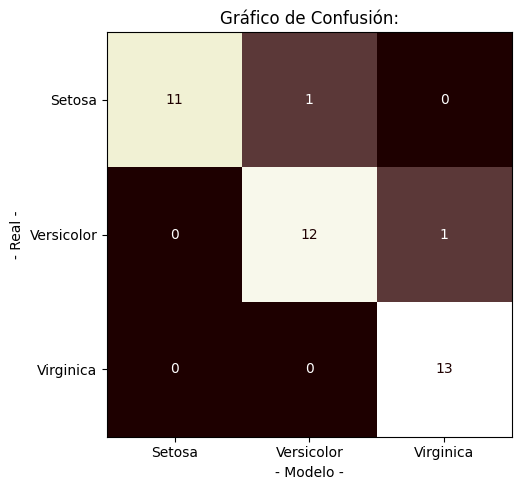

In [30]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = False #@param {type:"boolean"}

  # evalua al modelo entrenado
resEval = model.evaluate(x_test, (y_testEnc if tipo_output_softMax else y_test), verbose=0)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", round(resEval[0],3))
if esProblemaClasificacion:
  print("    - Exactitud: ", round(resEval[1]*100,2))
else:
  print("    - Distancia Media Cuadrática Mínima: ", round(resEval[1],3))

#print("\n")

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
if esProblemaClasificacion:
  probarModelo_Clasificacion(x_test, y_test, CLASES, umbral_clasificacion/100.0, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)
else:
  probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)


In [22]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/datosNeuroEvol'  #@param {type:"string"}

if guardar_modelo:

    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_model = path_modelo+"/model.keras"
    model.save(fn_model)
    print("\n-Modelo guardado en ", fn_model,"\n")

    if ("scaler" in locals()) and (scaler is not None):
      fn_scaler = path_modelo+"/SCALER.joblib"
      import joblib
      joblib.dump(scaler, fn_scaler)
      print("\n-SCALER para normalizar datos de entrada guardado en ", fn_scaler,"\n")

    if ("CLASES" in locals()) and (CLASES is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(CLASES)):
          f.write(str(i)+":"+str(CLASES[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", fn_clases,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosNeuroEvol/model.keras 


-CLASES_MAP para mostrar los resultados guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosNeuroEvol/CLASES_MAP.txt 

